# Using the COGITATE iEEG data 
Welcome to the COGITATE Consortium's iEEG Data Exploration Notebook! In this tutorial, we will guide you through the process of accessing and analyzing intracranial electroencephalography (iEEG) data collected as part of our consortium. The COGITATE consortium is an adversarial collaboration aiming to deepen our understanding of consciousness by comparing two prominent theories: Integrated Information Theory (IIT) and Global Neuronal Workspace (GNW).

The dataset we are sharing originates from experiments employing a carefully designed paradigm. Participants were presented with images from four distinct categories (faces, objects, letters and symbols), each displayed at three different orientations (center, left, and right). Furthermore, these images were shown for varying durations of 0.5, 1.0, and 1.5 seconds. At the beginning of each experimental block, participants were shown two specific target identities, representing either a specific face and a specific object. Participants were tasked with pressing a button when these target identities appeared. This introduced an additional task relevance condition: stimuli of the same category as the targets but of a different identity were deemed task-relevant, while stimuli from other categories were considered task-irrelevant. This comprehensive experimental design allows us to delve into the neural correlates of consciousness across different stimuli and temporal conditions while controlling for task demands.

This notebook serves a dual purpose: to provide a user-friendly guide on how to navigate, load, preprocess, and access specific data within our dataset, and to introduce the basics of iEEG data analysis. We will walk you through a simple univariate analysis, offering insights into individual channels, and a basic multivariate analysis, shedding light on the complex interplay of neural signals.


## Learning objectives
By the end of this tutorial, you will:

- Understand how to load and preprocess iEEG data from the COGITATE consortium
- Access and index specific data based on experimental conditions
- Perform a simple univariate analysis to examine the response patterns of individual channels
- Engage in a basic multivariate analysis to uncover relationships and patterns across multiple channels

<div style="background-color: #FFCCCC; padding: 10px; border-radius: 5px;">

## Disclaimer:

This notebook does not aim to replicate the analysis of the COGITATE consortium analyses ([SOURCE](insert_source_link_here)) but rather guide users to use our data. The code to replicate the results will be shared [here](insert_source_code_link_here).

</div>


In [16]:
# Setting all modules:
from pathlib import Path
import scipy
import mne
from mne.viz import plot_alignment, snapshot_brain_montage
from mne_bids import BIDSPath, read_raw_bids
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from pingouin import ttest

from pipelines.Preprocessing import preprocessing
from pipelines.OnsetResponsiveness import onset_responsiveness
from pipelines.Decoding import decoding
from HelperFunctions import get_roi_channels, create_mni_montage, get_cmap_rgb_values

import environment_variables as ev

# Fetch the fsaverage brain surface to plot the electrodes localization across subjects
fs_average_dir = Path(mne.datasets.sample.data_path(), 'subjects')
# use mne-python's fsaverage data
mne.datasets.fetch_fsaverage(subjects_dir=fs_average_dir, verbose=True)  # downloads if needed

0 files missing from root.txt in C:\Users\alexander.lepauvre\mne_data\MNE-sample-data\subjects
0 files missing from bem.txt in C:\Users\alexander.lepauvre\mne_data\MNE-sample-data\subjects\fsaverage


'C:\\Users\\alexander.lepauvre\\mne_data\\MNE-sample-data\\subjects\\fsaverage'

## Set up and download of the BIDS converted data
The first step is to specify the data that we will be working with, as well as the place to store them on the local machine. All path are specified under environment_variable.py. Make sure to edit this file to match your computer. For the purpose of this notebook, we will download the data of the first of the COGITATE for a couple of subjects.

In [17]:
# Print the path to the different data:
print("The following path are specified")
print("raw data root: ")
print("   {}".format(ev.raw_root))
print("bids root: ")
print("   {}".format(ev.bids_root))
print("freesurfer directory: ")
print("   {}".format(ev.fs_directory))
print("If this does not match what you expect, make sure to change the path under iEEG-data-release/environment_variable.py")

# Specify the subjects to work with:
subjects_list = ["CF102", "CE103"]
# Further specify the data to use from the subjects:
session = "V1"
datatype = "ieeg"
task = "Dur"

# Create the mne bids path object, making access to the data easier. We will use one example subject to demonstrate the details of our analyses. 
bids_path = BIDSPath(root=ev.bids_root, subject=subjects_list[0],
                     session='V1',
                     datatype='ieeg',
                     task='Dur')

The following path are specified
raw data root: 
   C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\data_release\raw
bids root: 
   C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\data_release\bids
freesurfer directory: 
   C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\data_release\bids\derivatives\fs
If this does not match what you expect, make sure to change the path under iEEG-data-release/environment_variable.py


As the data are organized according to the BIDS specification, we can use the mne bids functionalities to load the data, which we will showcase with one test subject.

In [6]:
%%capture
# Loading the data under the term broadband, as it is what they are as long as no further
# filtering was employed
raw = read_raw_bids(bids_path=bids_path, verbose=True);

Now that the data are lodaded, we can inspect them by plotting  the power spectrum density as well as the electrodes localization on the brain surface. 

In [ ]:
%%capture
# Compute and plot the PSD:
raw.compute_psd().plot(picks='data', exclude='bads', spatial_colors=False)

# Plot the channels localization on the subject's pial surface. 
fig = plot_alignment(
    info=raw.info,
    trans="fsaverage",
    subject=subjects_list[0],
    subjects_dir=ev.fs_directory,
    surfaces=["pial"],
    coord_frame="head",
    ecog=True, 
    seeg=False,
    sensor_colors=sensor_colors,
)

## Running the preprocessing
The BIDS downloaded data can then be preprocessed. In this code, we provide a preprocessing pipeline which applies the following
steps:
- Removal of bad channels 
- Notch filtering to remove line noise (60Hz)
- Re-referencing using Laplace scheme
- High gamma computations (70-150Hz)
- ERP computations (0-30Hz)
- Epoching
(See here for more details)

This preprocessing pipeline can be called using the provided function called preprocessing. This function requires 3 inputs:
- config_file: a json file specifying all the details of the steps to perform
- subjects_list: a list of the name of all the subjects on whom to apply the pipeline
- bids_root: path to the bids folder on the local drive.

The command below will apply the preprocessing pipeline as specified in the default config file of this repository, which follow
the specification of this paper. The pipeline is highly configurable and can be adjusted by specifying different options,
different order of steps and so on. If you wish to change the pipeline, we recommand you create a copy of the existing one
and rename it according to your needs.

In [ ]:
config_file = "pipelines/preprocessing_config-default.json"
preprocessing(config_file, subjects_list)

----------------------------------------
Welcome to preprocessing!
The following subjects will now be preprocessed: 
['CF102', 'CE103']
Using the config file:
pipelines/preprocessing_config-default.json
It may take some time, count roughly 5-10min per subject!
----------------------------------------
Preprocessing CF102 with config file pipelines/preprocessing_config-default.json
Reading 0 ... 1265151  =      0.000 ...  2470.998 secs...


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\pipelines\Preprocessing.py:88: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['G33', 'EKG1', 'EKG2']
  raw = {"broadband": read_raw_bids(bids_path=bids_path, verbose=verbose)}
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\pipelines\Preprocessing.py:88: RuntimeWarning: Not setting positions of 2 ecg channels found in montage:
['EKG1', 'EKG2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = {"broadband": read_raw_bids(bids_path=bids_path, verbose=verbose)}


Downsampling the signal to 512Hz, this may take a little while
<Info | 11 non-empty values
 bads: []
 ch_names: G1, G2, G3, G4, G5, G6, G7, G8, G9, G10, G11, G12, G13, G14, ...
 chs: 110 ECoG, 24 sEEG, 2 ECG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 134 items (134 EEG)
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 136
 projs: []
 sfreq: 512.0 Hz
 subject_info: 3 items (dict)
>
Detrending the data
Creating annotations
------------------------------------------------------------
Performing plot_channels_loc
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\data_release\bids\derivatives\fs\sub-CF102
Channel types::	ecog: 110
Channel types::	seeg: 24


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:885: RuntimeWarning: You have attempted to plot exclude channels, but none where found in your signal
  mne.utils.warn("You have attempted to plot {0} channels, but none where found in your signal".


Channel types::	ecog: 110
Channel types::	seeg: 24


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:885: RuntimeWarning: You have attempted to plot exclude channels, but none where found in your signal
  mne.utils.warn("You have attempted to plot {0} channels, but none where found in your signal".


------------------------------------------------------------
Performing description_bad_channels_rejection
Saving mne object
------------------------------------------------------------
Performing notch_filtering
Saving mne object
------------------------------------------------------------
Performing laplace_reference
The channel G33 to reference is bad and will be ignored
The channel G34 to reference is bad and will be ignored
The channel G35 to reference is bad and will be ignored
The channel G36 to reference is bad and will be ignored
The channel G37 to reference is bad and will be ignored
The channel G38 to reference is bad and will be ignored
The channel G41 to reference is bad and will be ignored
The channel G42 to reference is bad and will be ignored
The channel G43 to reference is bad and will be ignored
The channel G44 to reference is bad and will be ignored
The channel G45 to reference is bad and will be ignored
The channel G46 to reference is bad and will be ignored
The ref

C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


Relocating channel G8
Relocating channel G9


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


Relocating channel G16
Relocating channel G17


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


Relocating channel G24
Relocating channel G25


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


Relocating channel G32
Relocating channel G39
Relocating channel G40
Relocating channel G47
Relocating channel G48


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbo

Relocating channel G51
Relocating channel G56


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


Relocating channel G57


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


Relocating channel G64
Relocating channel LOF1
Relocating channel LOF2
Relocating channel LF1


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbo

Relocating channel LF6
Relocating channel LPF2
Relocating channel LPF6


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


Relocating channel LP1
Relocating channel LP6


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


Relocating channel LPO1


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


Relocating channel LPO8
Relocating channel LO1


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


Relocating channel LO8
Relocating channel DLAMT1
Relocating channel DLAMT4


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


Relocating channel DLPMT1
Relocating channel DLPMT2


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1217: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="warn")


Saving mne object
------------------------------------------------------------
Performing atlas_mapping
['G4', 'G15', 'G19', 'G22', 'G39', 'LPF2', 'LP1', 'LP5', 'LPO1', 'LPO5', 'LO3']
------------------------------------------------------------
Performing hg_computations
----------------------------------------
Welcome to frequency bands computation
1
Dividing channels amplitude by average amplitude
Dividing channels amplitude by average amplitude
Dividing channels amplitude by average amplitude
Dividing channels amplitude by average amplitude
Dividing channels amplitude by average amplitude
Dividing channels amplitude by average amplitude
Dividing channels amplitude by average amplitude
Dividing channels amplitude by average amplitude
Saving mne object
------------------------------------------------------------
Performing erp_computations
----------------------------------------
Welcome to erp computation
1
Saving mne object
-----------------------------------------------------------

C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:885: RuntimeWarning: You have attempted to plot ecog channels, but none where found in your signal
  mne.utils.warn("You have attempted to plot {0} channels, but none where found in your signal".


Channel types::	seeg: 58


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:885: RuntimeWarning: You have attempted to plot exclude channels, but none where found in your signal
  mne.utils.warn("You have attempted to plot {0} channels, but none where found in your signal".
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:885: RuntimeWarning: You have attempted to plot ecog channels, but none where found in your signal
  mne.utils.warn("You have attempted to plot {0} channels, but none where found in your signal".


Channel types::	seeg: 58


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:885: RuntimeWarning: You have attempted to plot exclude channels, but none where found in your signal
  mne.utils.warn("You have attempted to plot {0} channels, but none where found in your signal".


------------------------------------------------------------
Performing description_bad_channels_rejection
Saving mne object
------------------------------------------------------------
Performing notch_filtering
Saving mne object
------------------------------------------------------------
Performing laplace_reference
[] dropped because bad or surrounded by bad
0 bad channels
0 surrounded by bad channels
Relocating channel LA1


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


Relocating channel LA10
Relocating channel LAH1


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


Relocating channel LAH6
Relocating channel LMH1


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


Relocating channel LMH10
Relocating channel LPH1


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


Relocating channel LPH10
Relocating channel LAI1


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


Relocating channel LAI12
Relocating channel RA1


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)
C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


Relocating channel RA10
Saving mne object


C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\HelperFunctions.py:1308: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage, on_missing="ignore", verbose=verbose)


------------------------------------------------------------
Performing atlas_mapping
['LMH9', 'LMH10', 'LPH10', 'RA8']
------------------------------------------------------------
Performing hg_computations
----------------------------------------
Welcome to frequency bands computation
1
Dividing channels amplitude by average amplitude
Dividing channels amplitude by average amplitude
Dividing channels amplitude by average amplitude


### Visualizing the preprocessed data
The final output of the preprocessing pipeline are the epoched data. The naming conventions of the folders follow the BIDS conventions
You can therefore load the data as follows, and plot a single channel using mne functionalities

Reading C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\data_release\bids\derivatives\preprocessing\sub-CF102\ses-V1\ieeg\epoching\high_gamma\sub-CF102_ses-V1_task-Dur_desc-epoching_ieeg-epo.fif ...
    Found the data of interest:
        t =    -750.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 9 columns
1440 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1440 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 640x480 with 4 Axes>]

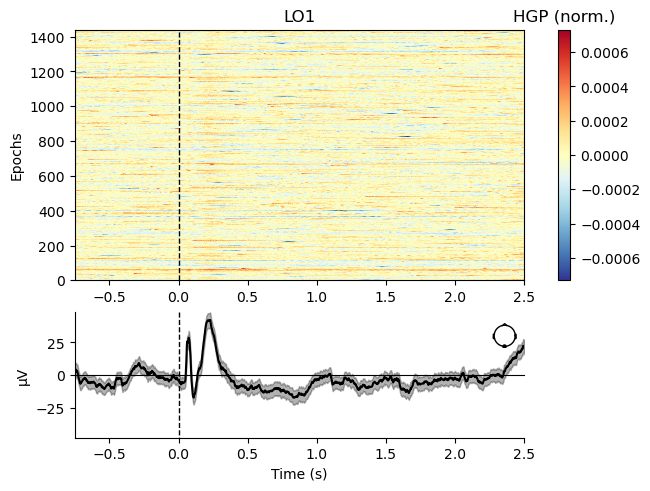

In [15]:
channel = 'LO1'
example_epochs_path = Path(ev.bids_root, 'derivatives', 'preprocessing',
                           'sub-' + subjects_list[0], 'ses-' + "V1", 'ieeg',
                           "epoching", 'high_gamma',
                           "sub-{}_ses-{}_task-{}_desc-epoching_{}-epo.fif".format(subjects_list[0],
                                                                                   "V1", "Dur",
                                                                                   "ieeg"))

epochs = mne.read_epochs(example_epochs_path, preload=True)
mne.viz.plot_epochs_image(epochs, picks=channel, 
                          show=False, units=dict(ecog="HGP (norm.)", seeg="HGP (norm.)"),
                          scalings=dict(ecog=1, seeg=1),
                          evoked=True, cmap="RdYlBu_r")

Notice that the figure above looks odd, with some activation in the baseline. That is because we have data that are epochs relative to both the onset and the offset of the stimuli for different analyses. For most purpose, we would need to select only the epochs locked to stimulus onset. This can be achieved by selecting the epochs by conditions, like so:

Not setting metadata
720 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 640x480 with 4 Axes>]

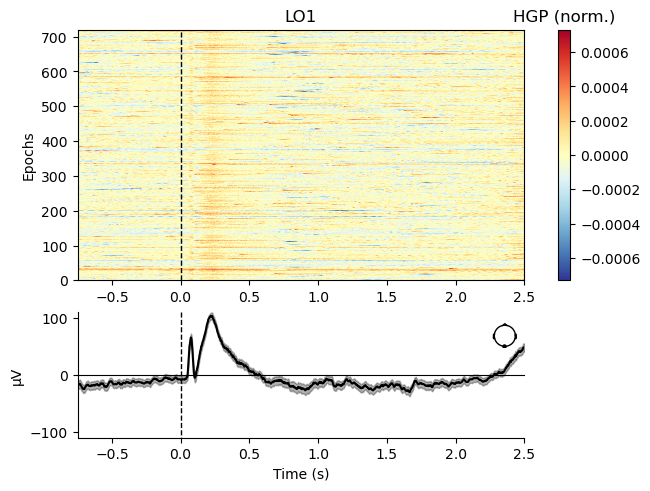

In [6]:
onset_locked_epochs = epochs['stimulus onset']
mne.viz.plot_epochs_image(onset_locked_epochs, picks=channel, 
                          show=False, units=dict(ecog="HGP (norm.)", seeg="HGP (norm.)"),
                          scalings=dict(ecog=1, seeg=1),
                          evoked=True, cmap="RdYlBu_r")

In general, if you wish to extract specific conditions, this data are equipped with forward slash separated strings, enabling you to select any condition by passing the according string or list of strings. Consult the documentation found XXX to find all the conditions
that can be accessed from the data.

In [ ]:
%%capture
task_relevant_epochs = epochs['stimulus onset/Relevant non-target']
mne.viz.plot_epochs_image(task_relevant_epochs, picks=channel, 
                          show=False, units=dict(ecog="HGP (norm.)", seeg="HGP (norm.)"),
                          scalings=dict(ecog=1, seeg=1),
                          evoked=True, cmap="RdYlBu_r")

In [ ]:
%%capture
task_relevant_face_short_epochs = epochs['stimulus onset/Relevant non-target/face/500ms']
mne.viz.plot_epochs_image(task_relevant_face_short_epochs, picks=channel, 
                          show=False, units=dict(ecog="HGP (norm.)", seeg="HGP (norm.)"),
                          scalings=dict(ecog=1, seeg=1),
                          evoked=True, cmap="RdYlBu_r")

## Onset responsiveness
Now that the data were preprocessed, we can apply the onset responsiveness analysis, which consists in comparing single channel activation before and after visual stimuli onsets. This enables determining which are the channels which are responsive to our task in general. To do so, we will compute a Bayes factor using the JZS Bayes Factor approximation described in [SOURCE]. This method consists in computing a paired t-test and using a formula to generate a Bayes factor. The main advantage of this approach is that it alleviates the need for multiple comparison correction. This way, the results will not change as a function of the number of subjects that gets added. 

Practically, we will first extract the trials locked to the onset of the stimuli and remove the target trials (as these require participants responses). We will then extract the pre (-0.3 to 0 sec. from stimulus onset) and post-stimulus (0.05 to 0.35 sec.) presentation segments for each trial. The data within each segment will be aggregated by computing the area under the curve (np.trapz). Finally, we will use the pingouin function ttest with the Cauchy scale factor set to 0.707 (default value in pingouin). 

We will first show an example on a single channel then proceed to show how to run it on all electrodes of selected subjects.

T-test results:
   T-stat=-29.742
   p-value=0.0
   BF=6.768e+118
   df=639


Text(0, 0.5, 'AUC difference')

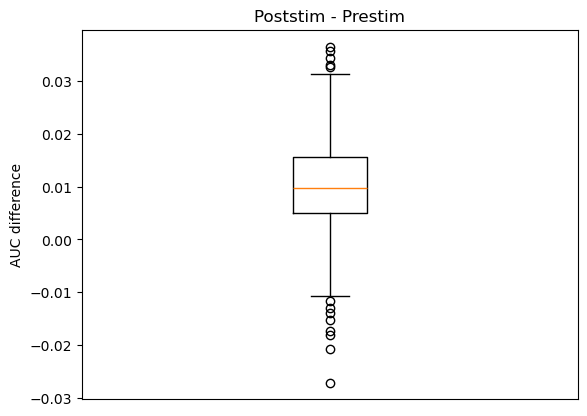

In [7]:
# Select the trials of interest:
onset_responsiveness_data =  epochs[["stimulus onset/Irrelevant", "stimulus onset/Relevant non-target"]]
# Crop the data:
prestim_data = np.squeeze(onset_responsiveness_data.copy().crop(tmin=-0.3, tmax=0).get_data(picks='LO1'))
poststim_data = np.squeeze(onset_responsiveness_data.copy().crop(tmin=0.05, tmax=0.350).get_data(picks='LO1'))
# Compute the AUC:
prestim_auc = np.trapz(prestim_data, axis=1)
poststim_auc = np.trapz(poststim_data, axis=1)
# Perform a two sided paired t-test:
results = ttest(prestim_auc, poststim_auc, paired=True, r=0.707, alternative='two-sided').round(3)

# Showing the results of the test:
print('T-test results:')
print('   T-stat={}'.format(results['T'].item()))
print('   p-value={}'.format(results['p-val'].item()))
print('   BF={}'.format(results['BF10'].item()))
print('   df={}'.format(results['dof'].item()))
fig, ax = plt.subplots()
ax.boxplot(poststim_auc - prestim_auc)
ax.set_title('Poststim - Prestim')
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_ylabel('AUC difference')

As we can see, the difference between pre and post-stimulus window is positive, indicating that HG activation is larger after stimulus onset. Accordingly, the bayes factor is really large, indicating that we have very strong evidence that this channel is responsive to our experimental paradigm.

### Onset responsiveness pipeline
The above example was applied to a single channel from a single participant. We further provide pipelines that enable the 
computation of onset responsiveness on all channels and subjects. As in the case of the preprocessing pipeline, this can
be achieved by calling the function onset_responsiveness which takes 3 mandatory inputs:
- config_file: a json file specifying the details of the analysis, such as the trials on which to apply the pipeline, pre and post stimuli time windows, metric to use...
- subjects_list: a list of the name of all the subjects on whom to apply the pipeline
- bids_root: path to the bids folder on the local drive.
Just as in the case of the pre-processing, the config files are highly configurable with many additional options. Make sure to visit XXX to investigate these options and how to specify them.

This function further takes two additional inputs:
- plot_single_channels: boolean flag to plot single electrodes or not
- plot_only_responsive: boolean flag to plot only those channels that were found to have differences in activation compared to baseline. 

Single channels plotting can take a long time, so you might want to deactivate it.

In [8]:
%%capture
config_file = "pipelines/onset_responsiveness_config-default.json"
results = onset_responsiveness(config_file, subjects_list[0], plot_single_channels=False, plot_only_responsive=False)

### Investigate the results
The pipeline generates a dataframe containing the results of the onset responsiveness test, with one row per channel, with the results of the test in the columns:
Now that we have ran the onset responsiveness analysis, we can provide some summary statistics for the 
data. 

In [9]:
print(results.head())

  subject    channel  statistic  pvalue     bf  reject     df  lowCI  highCI  \
0   CF102   CF102-G9     -2.998   0.003  3.777    True  639.0  -5.18   -1.08   
1   CF102  CF102-G10     -2.996   0.003  3.761    True  639.0  -4.97   -1.03   
2   CF102  CF102-G19     -0.101   0.920  0.045   False  639.0  -1.90    1.72   
3   CF102  CF102-G26      1.858   0.064  0.247   False  639.0  -0.15    5.39   
4   CF102  CF102-G27     -1.702   0.089  0.187   False  639.0  -3.21    0.23   

     f_size  
0  0.118592  
1  0.118536  
2  0.003978  
3 -0.073501  
4  0.067318  


We can investigate the results to assess how many electrodes show a change in activation, and for how many activation increases and decreases compared to the baseline period

In [10]:
# Channels counts:
responsive_channels = results[results['reject'] == True]
activated_channels = results[(results['reject'] == True) & (results['f_size'] > 0)]
deactivated_channels = results[(results['reject'] == True) & (results['f_size'] < 0)]
# Print the counts:
print("{} out of {} ({:.2f}%) were found to be onset responsive!".format(
    responsive_channels.shape[0], 
    results.shape[0],
    responsive_channels.shape[0] / results.shape[0] * 100))
print("{} out of {} ({:.2f}%) showed an increase of activation following  stimulus onset!".format(
    activated_channels.shape[0], 
    results.shape[0],
    activated_channels.shape[0] / results.shape[0] * 100
))
print("{} out of {} ({:.2f}%) showed an decrease of activation following  stimulus onset!".format(
    deactivated_channels.shape[0], 
    results.shape[0],
    deactivated_channels.shape[0] / results.shape[0] * 100
))

3 out of 26 (11.54%) were found to be onset responsive!
2 out of 26 (7.69%) showed an increase of activation following  stimulus onset!
1 out of 26 (3.85%) showed an decrease of activation following  stimulus onset!


We can also further investigate the results by looking at each subject separately:

In [11]:
subjects_channels_counts = results.groupby(["subject", "reject"]).count().reset_index()[["subject", "reject", "channel"]]
# Print the counts:
print(subjects_channels_counts.loc[subjects_channels_counts["reject"] == True, ["subject", "channel"]])

  subject  channel
1   CF102        3


### Plotting responsive channels on the brain surface
One important sanity check is to make sure that the localization of the effects make sense. As 
the task in the COGITATE was visual, one would expect to find a lot of onset responsive electrodes
over the posterior cortex. To check whether that is the case, we will extract only the onset responsive
electrodes that we hve identified above and we will plot that on the pial surface. 

This step require MNE setup to have been performed as to allow 3D rendering. Consult the MNE webpage: XXX

In [12]:
# Extract the onset responsive electrodes:
onset_responsive_results = results.loc[results["reject"] == True]
# Get these channels localization in MNI space:
mni_info = create_mni_montage(onset_responsive_results["channel"].to_list(), bids_path, ev.fs_directory, fs_average_dir)

# We can now go ahead and plot the ecog channels on the brain:
# Plot the ecog:
fig = plot_alignment(
    info=mni_info,
    trans="fsaverage",
    subject="fsaverage",
    subjects_dir=fs_average_dir,
    surfaces=["pial"],
    coord_frame="head",
    ecog=True, 
    seeg=False,
    sensor_colors=[[1.0, 1.0, 1.0, 0.8]] * len(mni_info.ch_names),
)
mne.viz.set_3d_view(fig, azimuth=180, elevation=70, focalpoint="auto", distance=0.4)
xy, im = snapshot_brain_montage(fig, mni_info)
fig2, ax2 = plt.subplots()
ax2.imshow(im_ecog)
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\alexander.lepauvre\\Documents\\GitHub\\iEEG-data-release\\data_release\\bids\\sub-CF102\\ses-V1\\ieeg\\sub-CF102_ses-V1_space-Other_electrodes.tsv'

Additionally, not only do we expect more channels to be responsive in posterior regions, we also expect the effects to be stronger. To vizualize this, you can plot the effect sizes of the onset
responsiveness on the brain.

In [ ]:
# Extract the effect sizes:
f_sizes = onset_responsive_results["f_size"].to_list()

# Get the RGB values for effect sizes mapped onto a colormap
sensor_colors = get_cmap_rgb_values(f_sizes, cmap=None, center=0)

# We can now go ahead and plot the dig montage on the brain:
fig = plot_alignment(
    info=mni_info,
    trans="fsaverage",
    subject="fsaverage",
    subjects_dir=fs_average_dir,
    surfaces=["pial"],
    coord_frame="head",
    ecog=True, 
    seeg=False,
    sensor_colors=sensor_colors,
)
mne.viz.set_3d_view(fig, azimuth=180, elevation=70, focalpoint="auto", distance=0.4)

xy, im = snapshot_brain_montage(fig, mni_info)
xy_pts = np.vstack([xy[ch] for ch in mni_info.ch_names])
fig2, ax2 = plt.subplots()
ax2.imshow(im)
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)
plt.show()

The colorbar is centered on 0, such that channels showing an increase in effect size are plotted in yellow/red tones while the channels showing a decrease in activation are plotted in blueish tones. As is to be expected, the channels located in occipital regions show the strongest effect sizes, but onset responsive electrodes can be found in several cortical locations

### Investigate specific regions of interest
We further provide functionalities to extract channels located in specific regions of interest. This will be illustrated by extracting channels located within the visual cortex. We will extract all channels located within the G_cuneus, G_occipital_sup, G_occipital_sup, Pole_occipital, S_calcarine, S_oc_sup_and_transversal, S_oc_middle_and_Lunatus as defined by the Destrieux atlas.

In [ ]:
# Define the list of regions of interest:
rois = ["Pole_occipital",
        "G_occipital_middle",
        "G_cuneus",
       ]
# Extract the channels within this ROI:
roi_channels = get_roi_channels(epochs.ch_names, rois, bids_path, 'aparc.a2009s+aseg')
print('The following channels were found in the ROI')
print(roi_channels)
# Extract the onset responsiveness results for the channels only:
roi_onset_responsiveness = results.loc[results['channel'].isin(['-'.join(['SF102', channel]) for channel in roi_channels])]
channels_counts = roi_onset_responsiveness.groupby("reject").count().reset_index()[["reject", "channel"]]

# Create a montage for these channels alone:
roi_mni_info = create_mni_montage(roi_onset_responsiveness["channel"].to_list(), bids_path, ev.fs_directory, fs_average_dir)

# Extract the effect sizes:
roi_f_sizes = roi_onset_responsiveness["f_size"].to_list()

# Get the RGB values for effect sizes mapped onto a colormap
roi_sensor_colors = get_cmap_rgb_values(roi_f_sizes, cmap="Oranges", center=None)

# We can now go ahead and plot the dig montage on the brain:
fig = plot_alignment(
    info=roi_mni_info,
    trans="fsaverage",
    subject="fsaverage",
    subjects_dir=fs_average_dir,
    surfaces=["pial"],
    coord_frame="head",
    ecog=True, 
    seeg=False,
    sensor_colors=roi_sensor_colors,
)
mne.viz.set_3d_view(fig, azimuth=180, elevation=70, focalpoint="auto", distance=0.4)

xy, im = snapshot_brain_montage(fig, mni_info)
xy_pts = np.vstack([xy[ch] for ch in mni_info.ch_names])
fig2, ax2 = plt.subplots()
ax2.imshow(im)
ax2.yaxis.set_visible(False)
ax2.xaxis.set_visible(False)
plt.show()

## Decoding
In addition to investigate the univariate responses of every single channel, we can also performed a multivariate analysis, investigating the presence of representation of particular contrasts of interests across the electrodes in our sample. In the current example, we will
use support vector machine to decode faces vs. objects across all electrodes within our example subject.

We will perform temporal generalization decoding using support vector machine for the faces vs objects labels in the task irrelevant trials. We will first prepare the data by selecting only seeg and ecog channels, downsample the data and select the conditions of interest. We will then create a classifier and apply it to our data with 5 fold cross validation and score the decoding accuracy using roc_auc. 

In [ ]:
# Import the required libraries:
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from mne.decoding import (GeneralizingEstimator, cross_val_multiscore)


#Select electrodes:
picks = mne.pick_types(epochs.info, ecog=True, seeg=True)
decoding_epochs = epochs.copy().pick(picks)
# Downsample:
decoding_epochs.resample(30, n_jobs=1)
# Select trials:
decoding_epochs = decoding_epochs[["stimulus onset/Irrelevant/face", "stimulus onset/Irrelevant/object"]]

# Create the classifier:
clf_steps = []
clf_steps.append(StandardScaler())
clf_steps.append(svm.SVC(kernel='linear', class_weight='balanced'))
clf = make_pipeline(*clf_steps)
# Temporal generalization estimator:
time_gen = GeneralizingEstimator(clf, n_jobs=1, scoring='roc_auc',
                                 verbose="ERROR")

# Extract the data:
data = decoding_epochs.get_data()
# Get the classes:
y = decoding_epochs.metadata["category"].values
# Run the decoding:
scores = cross_val_multiscore(time_gen, data, y, cv=5, n_jobs=None)

# Plot the results:
fig, ax = plt.subplots()
# Plot matrix with transparency:
im = ax.imshow(np.mean(scores, axis=0), cmap="RdYlBu_r",
               extent=[epochs.times[0], epochs.times[-1], epochs.times[0], epochs.times[-1]],
               origin="lower",  # aspect="equal",
               interpolation="lanczos", vmin=0, vmax=1)
# Add the axis labels and so on:
ax.set_xlim([epochs.times[0], epochs.times[-1]])
ax.set_ylim([epochs.times[0], epochs.times[-1]])
ax.set_xlabel("Testing time (s)")
ax.set_ylabel("Training time (s)")
ax.set_title("Decoding of {}".format("faces vs. objects"))
ax.axvline(0, color='k')
ax.axhline(0, color='k')
fig.colorbar(im, fraction=0.046, pad=0.04)

### Decoding pipeline
The above example was applied to a single participant. We further provide pipelines to perform decoding on all subjects. This can be achieved by calling the function decoding which takes 3 mandatory inputs:

- config_file: a json file specifying the details of the analysis, such as trials to select, decoding targets, cross task generalization...
- subjects_list: a list of the name of all the subjects on whom to apply the pipeline
- bids_root: path to the bids folder on the local drive. Just as in the case of the pre-processing, the config files are highly configurable with many additional options. Make sure to visit XXX to investigate these options and how to specify them.


In [ ]:
subjects_list = ["SF102"]
config_file = "pipelines/decoding_config-default.json"
scores = decoding(config_file, subjects_list)

### Decoding within regions of interest
In the case of decoding, it is especially relevant to be able to investigate spatial specificy. This can be achieved as shown in the onset responsiveness analysis by pre-selecting channels based on their anatomical labels. We will here show how to do so by selecting channels located within a posterior ROI defined by the following labels:



In [ ]:
rois = ["Pole_occipital",
        "G_occipital_middle",
        "G_cuneus",]
# Extract the channels within this ROI:
roi_channels = get_roi_channels(epochs.ch_names, rois, bids_path, 'aparc.a2009s+aseg')
print('The following channels were found in the ROI')
print(roi_channels)

# Selecting those channels only:
roi_epochs = epochs.copy().pick(roi_channels)
# Downsample:
roi_epochs.resample(30, n_jobs=1)
# Select trials:
roi_epochs = roi_epochs[["stimulus onset/Irrelevant/face", "stimulus onset/Irrelevant/object"]]

# Create the classifier:
clf_steps = []
clf_steps.append(StandardScaler())
clf_steps.append(svm.SVC(kernel='linear', class_weight='balanced'))
clf = make_pipeline(*clf_steps)
# Temporal generalization estimator:
time_gen = GeneralizingEstimator(clf, n_jobs=1, scoring='roc_auc',
                                 verbose="ERROR")

# Extract the data:
data = roi_epochs.get_data()
# Get the classes:
y = roi_epochs.metadata["category"].values
# Run the decoding:
scores = cross_val_multiscore(time_gen, data, y, cv=5, n_jobs=None)

# Plot the results:
fig, ax = plt.subplots()
# Plot matrix with transparency:
im = ax.imshow(np.mean(scores, axis=0), cmap="RdYlBu_r",
               extent=[epochs.times[0], epochs.times[-1], epochs.times[0], epochs.times[-1]],
               origin="lower",  # aspect="equal",
               interpolation="lanczos", vmin=0, vmax=1)
# Add the axis labels and so on:
ax.set_xlim([epochs.times[0], epochs.times[-1]])
ax.set_ylim([epochs.times[0], epochs.times[-1]])
ax.set_xlabel("Testing time (s)")
ax.set_ylabel("Training time (s)")
ax.set_title("Decoding of {}".format("faces vs. objects"))
ax.axvline(0, color='k')
ax.axhline(0, color='k')
fig.colorbar(im, fraction=0.046, pad=0.04)